In [583]:
#import all libraries needed
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import numpy as np
import pylab
import math

from scipy import stats

import statsmodels.api as sm
from statsmodels.stats import diagnostic as diag
from statsmodels.stats.outliers_influence import variance_inflation_factor

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error

%matplotlib inline

In [584]:
#choose file to get data from
filein = 'oldAndNewOnlyEnglish_noDuplicatesWithLikesAndComments.csv'

#load data
columns = ["videoTitle", "videoViews"]
df = pd.read_csv(filein, usecols = columns)
titles_df  = df["videoTitle"]
views_df = df["videoViews"]
data_df = df["videoViews"]

#Get different title analyses
titleLengths_df = titles_df.str.len()
titleLengths_df = titleLengths_df.rename('titleLength')
numCaps_df = titles_df.str.count(r'[A-Z]')
numCaps_df = numCaps_df.rename('numCaps')
numPuncs_df = titles_df.str.count('!') + titles_df.str.count('\?')
numPuncs_df = numPuncs_df.rename('numPuncs')

#combine into one dataframe
data_df = pd.concat([views_df, titleLengths_df, numCaps_df,
                     numPuncs_df], axis = 1)
data_df


,videoViews,titleLength,numCaps,numPuncs
0,5718766,96,12,0
1,2742984,28,3,0
2,2682879,33,5,0
3,1846670,54,8,1
4,1788176,56,18,0
...,...,...,...,...
25694,890248,22,7,0
25695,1065386,29,17,0
25696,360652,45,6,0
25697,4178111,27,3,0


,videoViews,titleLength,numCaps,numPuncs
videoViews,1.000000,-0.019309,-0.015410,-0.027555
titleLength,-0.019309,1.000000,0.338878,0.016766
numCaps,-0.015410,0.338878,1.000000,0.263317
numPuncs,-0.027555,0.016766,0.263317,1.000000


const          7.342981
videoViews     1.001120
titleLength    1.137312
numCaps        1.221353
numPuncs       1.082106
dtype: float64

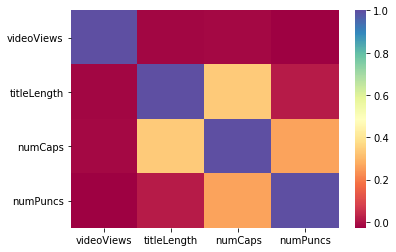

In [585]:
#checking for perfect multicolinearity
correlation = data_df.corr()
display(correlation)
sns.heatmap(correlation, xticklabels = correlation.columns,
            yticklabels = correlation.columns, cmap = "Spectral")

#as seen below there is no very high or very low correlations
#therefore we probably do not need to eliminate any columns
#but lets just make sure by checking with variance_inflation_factor
cx = sm.tools.add_constant(data_df)
series = pd.Series([variance_inflation_factor(cx.values, i)
                          for i in range(cx.shape[1])], 
               index = cx.columns)
display(series)

#since the general rule is to remove if greater than five, we 
#will not need to remove any coumns (and I'm choosing to keep const)

In [586]:
#lets look at the data again
desc_df = data_df.describe()
desc_df.loc['+2_std'] = desc_df.loc['mean'] + (desc_df.loc['std']*2)
desc_df.loc['-2_std'] = desc_df.loc['mean'] - (desc_df.loc['std']*2)
print(data_df['videoViews'].skew())
print(data_df['titleLength'].skew())
print(data_df['numCaps'].skew())
print(data_df['numPuncs'].skew())

desc_df
#as we can see below, videoViews has the most skew, so we should 
#change that somehow

29.807410149113874
0.384199060508636
2.3226704326968606
3.451420353780659


,videoViews,titleLength,numCaps,numPuncs
count,2.569900e+04,25699.000000,25699.000000,25699.000000
mean,1.236903e+06,52.711662,11.302697,0.241838
std,6.599134e+06,21.398028,9.484438,0.604481
min,5.590000e+02,1.000000,0.000000,0.000000
25%,1.247540e+05,36.000000,5.000000,0.000000
50%,3.241420e+05,50.000000,9.000000,0.000000
75%,8.401375e+05,67.000000,14.000000,0.000000
max,4.245389e+08,100.000000,83.000000,9.000000
+2_std,1.443517e+07,95.507718,30.271572,1.450800
-2_std,-1.196137e+07,9.915606,-7.666179,-0.967124


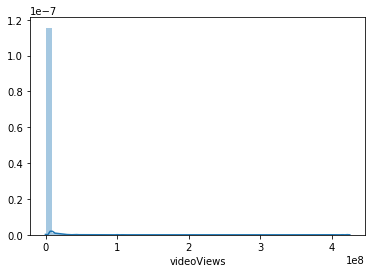

In [587]:
#lets fix the views skew!
#show original disaster
sns.distplot(data_df['videoViews'])

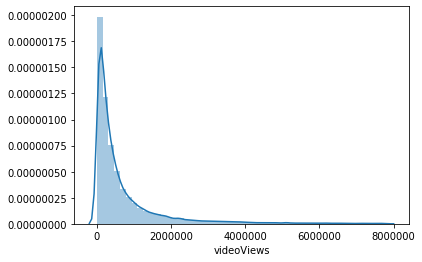

In [588]:
#remove excessively outlied outliers
viewdes = data_df['videoViews'].describe()
std = viewdes.get(key = 'std')
mean = viewdes.get(key = 'mean')
meandist = abs(data_df['videoViews'] - mean)
nonoutlier = meandist < std
data_df = data_df[nonoutlier]
#plot difference now that outliers have been removed
sns.distplot(data_df['videoViews'])

-0.45682495110454735


,logViews,videoViews,titleLength,numCaps,numPuncs
count,25155.000000,2.515500e+04,25155.000000,25155.000000,25155.000000
mean,12.582666,7.019096e+05,52.743550,11.336752,0.244643
std,1.453990,1.063100e+06,21.371637,9.521765,0.607016
min,6.326149,5.590000e+02,1.000000,0.000000,0.000000
25%,11.709088,1.216725e+05,37.000000,5.000000,0.000000
50%,12.653374,3.128170e+05,50.000000,9.000000,0.000000
75%,13.573064,7.847060e+05,67.000000,14.000000,0.000000
max,15.868992,7.794990e+06,100.000000,83.000000,9.000000


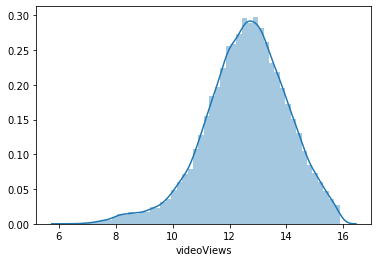

In [589]:
viewslog = np.log(data_df['videoViews'])
sns.distplot(viewslog)
print(viewslog.skew())
viewslog = viewslog.rename(index = "logViews")
data_df = pd.concat((viewslog, data_df), axis = 1)
desc_df = data_df.describe()
desc_df

In [590]:
#lets build the model
#separate inputs and outputs
x = data_df.drop({'videoViews', 'logViews'}, axis = 1)
y = data_df[['logViews']]

#split into training and testing
xtrain, xtest, ytrain, ytest = train_test_split(
    x, y, test_size = 0.20, random_state = 1)

regmod = LinearRegression()
regmod.fit(xtrain, ytrain)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [591]:
#lets test some stuff!
ypred = np.exp(regmod.predict(xtest))

ypred[:5]

array([[299464.93801491],
       [280805.29273467],
       [273969.55201867],
       [322242.23219033],
       [275759.08822761]])

In [592]:
#check fit of model
dx = sm.add_constant(x)
model = sm.OLS(y, dx)
fitx = model.fit()

#run breusch-pagan test for heteroscedaticity
_,pval,_,fpval  = diag.het_breuschpagan(fitx.resid,
                                         fitx.model.exog,)
print(pval, fpval)
#since pvals are more significant than 0.05, this is where we fail
# to reject that there is no heterodasticity (a good thing)

5.001975610824008e-27 4.317400294824201e-27


/Users/Preethi/opt/anaconda3/lib/python3.7/site-packages/statsmodels/stats/diagnostic.py:524: FutureWarning: The value returned will change to a single DataFrame after 0.12 is released.  Set return_df to True to use to return a DataFrame now.  Set return_df to False to silence this warning.
  warnings.warn(msg, FutureWarning)


0.0


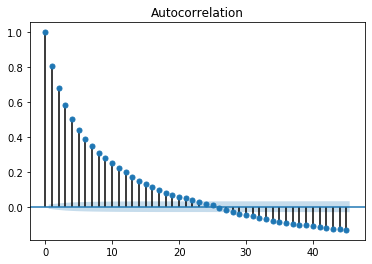

In [593]:
#check autocorrelation use ljung-box test
lag = min(10, (len(x)//5))

tests = diag.acorr_ljungbox(fitx.resid, lags = lag)

ibval, pval = tests

print(min(pval))
#since the smallest pval is so small, we reject that the data
#is random (a not so good thing)

#lets plot for visual confirmation
sm.graphics.tsa.plot_acf(fitx.resid)
plt.show()
#those few values goimg outside the range indicate autocorrelation

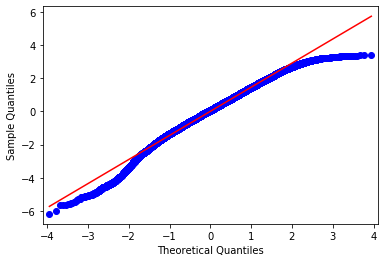

4.03431787855044e-15

In [594]:
#check means of residuals = 0 
sm.qqplot(fitx.resid, line = 's')
pylab.show()
meanres = sum(fitx.resid)/len(fitx.resid)
meanres

#the mean is close to zero, though it could be closer, but 
#we're good to move on

In [595]:
#use rmse to check error of model
rmse = math.sqrt(mean_squared_error(ytest, ypred))
rmse
#this is in views btw

291750.6600903054

In [596]:
#summary of model output
print(fitx.summary())

                            OLS Regression Results                            
Dep. Variable:               logViews   R-squared:                       0.004
Model:                            OLS   Adj. R-squared:                  0.003
Method:                 Least Squares   F-statistic:                     30.26
Date:                Sun, 12 Jul 2020   Prob (F-statistic):           1.62e-19
Time:                        22:13:55   Log-Likelihood:                -45063.
No. Observations:               25155   AIC:                         9.013e+04
Df Residuals:                   25151   BIC:                         9.017e+04
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                  coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------------------
const          12.6416      0.025    510.946      

Given these parameters for a video title:
Length: 10
Number of Capital Letters: 10
Number of Punctiation Marks (! and ?): 0
The number of views on the video will be 324666 views.
       logViews      predicted
6437   155012.0  280805.292735
21730  644853.0  273969.552019
17516  551608.0  322242.232190
23329  202821.0  275759.088228
7929   541482.0  379415.535055
...         ...            ...
10250  490391.0  371049.893731
13453  138596.0  293581.418428
24019  343286.0  281090.743995
24863  669179.0  261963.837403
3657   197588.0  283214.402838

[2988 rows x 2 columns]
       logViews      predicted
6437   155012.0  280805.292735
21730  644853.0  273969.552019
17516  551608.0  322242.232190
23329  202821.0  275759.088228
7929   541482.0  379415.535055
22689  350217.0  265295.888430
3352   362629.0  280226.157217
15397  300292.0  375793.877659
6716   166418.0  288104.163659
23499  340886.0  353426.268623
19698  182925.0  307153.461785
12519  183893.0  252970.203706
7263   560358.0  2917

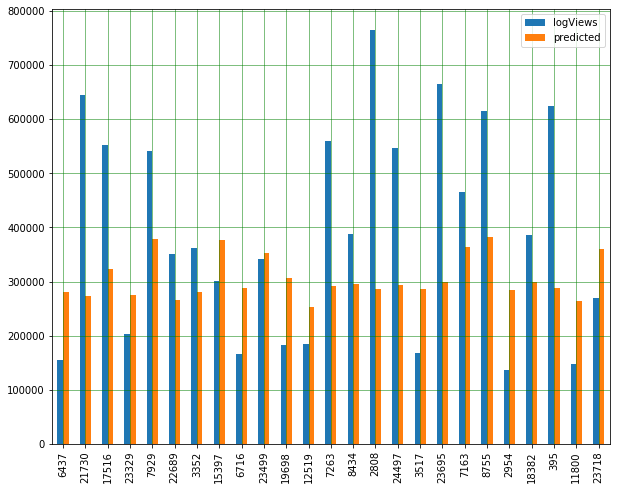

In [597]:
#use this space for predictions
titleLength = 10
numCaps = 10
numPuncs = 0

prediction = regmod.predict([[titleLength, numCaps, numPuncs]])
p = np.exp(prediction[0][0])

print('Given these parameters for a video title:')
print('Length: '+ str(titleLength))
print('Number of Capital Letters: ' + str(numCaps))
print('Number of Punctiation Marks (! and ?): ' + str(numPuncs))
print('The number of views on the video will be ' + str(int(p)) + " views.")


#plot graph of the model (just n values for reference)
n = 25
ytestfinal = np.exp(ytest)
actpred = ytestfinal
actpred['predicted'] = ypred
include = (actpred['logViews'] < 1000000) & (actpred['logViews'] > 100000)
actpredh = actpred[include]
print(actpredh)
actpredh =  actpredh.head(n)
print(actpredh)

actpredh.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

RMSE for views between 1106 and 776793:
205812.92705517248
RMSE for views between 776793 and 1552480:
822099.9315034843
RMSE for views between 1552480 and 2328167:
1602047.505946812
RMSE for views between 2328167 and 3103854:
2397357.8374269125
RMSE for views between 3103854 and 3879541:
3206736.3150240257
RMSE for views between 3879541 and 4655228:
3947686.5827061934
RMSE for views between 4655228 and 5430915:
4796006.448072254
RMSE for views between 5430915 and 6206602:
5565944.605331952
RMSE for views between 6206602 and 6982289:
6255582.242798038
RMSE for views between 6982289 and 7757976:
7086710.481205265
[[1.54161724e-02 1.10600000e+03]
 [6.15784173e-02 7.76793000e+05]
 [1.19999462e-01 1.55248000e+06]
 [1.79571237e-01 2.32816700e+06]
 [2.40196769e-01 3.10385400e+06]
 [2.95696767e-01 3.87954100e+06]
 [3.59239157e-01 4.65522800e+06]
 [4.16910459e-01 5.43091500e+06]
 [4.68566946e-01 6.20660200e+06]
 [5.30821617e-01 6.98228900e+06]]


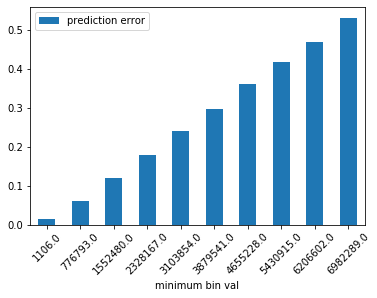

In [598]:
#calculate accuracy for different ranges
bins = 10
mn = actpred['logViews'].min()
mx = actpred['logViews'].max()
binsize = np.ceil((mx - mn)/bins)
avgdiff = np.array([])
binsrange = np.array([])
for b in range(bins):
    inbin = ((mn + (b*binsize)) <= actpred['logViews']) & ((mn + ((b+1)*binsize)) > actpred['logViews'])
    binned = actpred[inbin]
    if binned.size > 0:
        rmse = math.sqrt(mean_squared_error(binned['logViews'], binned['predicted']))
        diffavg = np.sum(abs(binned['logViews'] - binned['predicted']))/(binned['logViews'].size)
        print("RMSE for views between " + str(int(mn + (b*binsize))) + " and " +
              str(int(mn + ((b+1)*binsize))) + ":")
        print(rmse)
        avgdiff = np.append(avgdiff, rmse)
        binsrange = np.append(binsrange, int(mn + (b*binsize)))
avgdiff = avgdiff/np.linalg.norm(avgdiff)
acc = np.concatenate((avgdiff.reshape(-1, 1), binsrange.reshape(-1, 1)), axis = 1)
print(acc)
acc_df = pd.DataFrame(acc, columns = ['prediction error', 'minimum bin val'])
acc_df.plot.bar(x='minimum bin val', y='prediction error', rot=45)

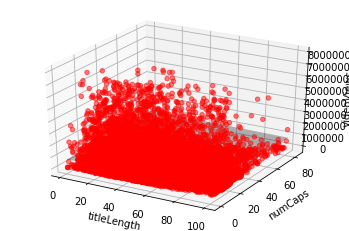

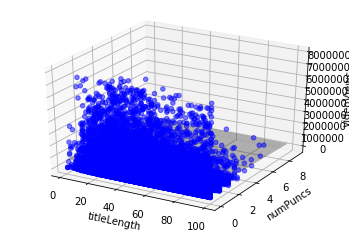

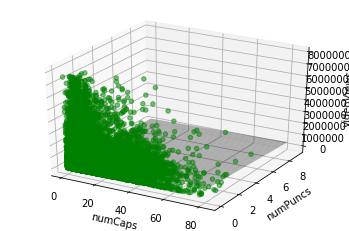

In [599]:
import statsmodels.formula.api as smf
from mpl_toolkits.mplot3d import Axes3D
#okay now lets try visualizing some stuff
#for this, the most we can really show is
#three dimensions, so I wll be creating 
#separate models for two variables at a time
#vs the number of views and we will have a
#total of three graphs in the end

y = data_df[['videoViews']]

x1 = data_df.drop({'numPuncs'}, axis = 1)
x2 = data_df.drop({'numCaps'}, axis = 1)
x3 = data_df.drop({'titleLength'}, axis = 1)

#Graph 1
model1 = smf.ols(formula = 'videoViews ~ titleLength + numCaps',
                 data = x1)
formula1 = model1.fit()
formula1.params

x1surf, y1surf = np.meshgrid(np.linspace(x1.titleLength.min(),
                                       x1.titleLength.max(), 100), 
                           np.linspace(x1.numCaps.min(),
                                       x1.numCaps.max(), 100))
onlyx1 = pd.DataFrame({'titleLength': x1surf.ravel(), 
                       'numCaps': y1surf.ravel()})
fittedy1 = formula1.predict(exog = onlyx1)
fittedy1 = np.array(fittedy1)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection = '3d')
ax1.scatter(x1['titleLength'], x1['numCaps'], x1['videoViews'], c = 'red',
          marker = 'o', alpha = 0.5)
ax1.plot_surface(x1surf, y1surf, fittedy1.reshape(x1surf.shape),
                color = 'None', alpha = 0.3)
ax1.set_xlabel('titleLength')
ax1.set_ylabel('numCaps')
ax1.set_zlabel('videoViews')
plt.show()


#Graph 2
model2 = smf.ols(formula = 'videoViews ~ titleLength + numPuncs',
                 data = x2)
formula2 = model2.fit()
formula2.params

x2surf, y2surf = np.meshgrid(np.linspace(x2.titleLength.min(),
                                       x2.titleLength.max(), 100), 
                           np.linspace(x2.numPuncs.min(),
                                       x2.numPuncs.max(), 100))
onlyx2 = pd.DataFrame({'titleLength': x2surf.ravel(), 
                       'numPuncs': y2surf.ravel()})
fittedy2 = formula2.predict(exog = onlyx2)
fittedy2 = np.array(fittedy2)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection = '3d')
ax2.scatter(x2['titleLength'], x2['numPuncs'], x2['videoViews'], c = 'blue',
          marker = 'o', alpha = 0.5)
ax2.plot_surface(x2surf, y2surf, fittedy2.reshape(x2surf.shape),
                color = 'None', alpha = 0.3)
ax2.set_xlabel('titleLength')
ax2.set_ylabel('numPuncs')
ax2.set_zlabel('videoViews')
plt.show()



#Graph 3
model3 = smf.ols(formula = 'videoViews ~ numCaps + numPuncs',
                 data = x3)
formula3 = model3.fit()
formula3.params

x3surf, y3surf = np.meshgrid(np.linspace(x3.numCaps.min(),
                                       x3.numCaps.max(), 100), 
                           np.linspace(x3.numPuncs.min(),
                                       x3.numPuncs.max(), 100))
onlyx3 = pd.DataFrame({'numCaps': x3surf.ravel(), 
                       'numPuncs': y3surf.ravel()})
fittedy3 = formula3.predict(exog = onlyx3)
fittedy3 = np.array(fittedy3)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection = '3d')
ax3.scatter(x3['numCaps'], x3['numPuncs'], x3['videoViews'], c = 'green',
          marker = 'o', alpha = 0.5)
ax3.plot_surface(x3surf, y3surf, fittedy3.reshape(x3surf.shape),
                color = 'None', alpha = 0.3)
ax3.set_xlabel('numCaps')
ax3.set_ylabel('numPuncs')
ax3.set_zlabel('videoViews')
plt.show()

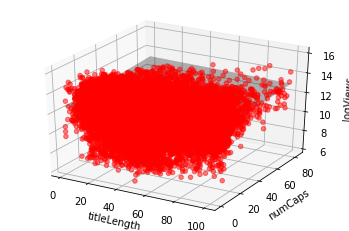

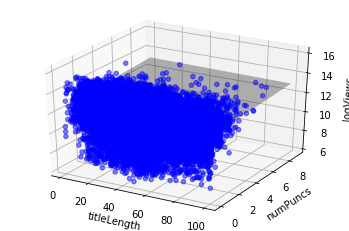

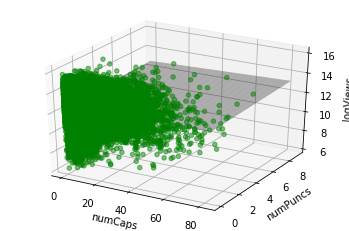

In [600]:
x1 = data_df.drop({'numPuncs'}, axis = 1)
x2 = data_df.drop({'numCaps'}, axis = 1)
x3 = data_df.drop({'titleLength'}, axis = 1)

#Graph 1
model1 = smf.ols(formula = 'logViews ~ titleLength + numCaps',
                 data = x1)
formula1 = model1.fit()
formula1.params

x1surf, y1surf = np.meshgrid(np.linspace(x1.titleLength.min(),
                                       x1.titleLength.max(), 100), 
                           np.linspace(x1.numCaps.min(),
                                       x1.numCaps.max(), 100))
onlyx1 = pd.DataFrame({'titleLength': x1surf.ravel(), 
                       'numCaps': y1surf.ravel()})
fittedy1 = formula1.predict(exog = onlyx1)
fittedy1 = np.array(fittedy1)

fig1 = plt.figure()
ax1 = fig1.add_subplot(111, projection = '3d')
ax1.scatter(x1['titleLength'], x1['numCaps'], x1['logViews'], c = 'red',
          marker = 'o', alpha = 0.5)
ax1.plot_surface(x1surf, y1surf, fittedy1.reshape(x1surf.shape),
                color = 'None', alpha = 0.3)
ax1.set_xlabel('titleLength')
ax1.set_ylabel('numCaps')
ax1.set_zlabel('logViews')
plt.show()


#Graph 2
model2 = smf.ols(formula = 'logViews ~ titleLength + numPuncs',
                 data = x2)
formula2 = model2.fit()
formula2.params

x2surf, y2surf = np.meshgrid(np.linspace(x2.titleLength.min(),
                                       x2.titleLength.max(), 100), 
                           np.linspace(x2.numPuncs.min(),
                                       x2.numPuncs.max(), 100))
onlyx2 = pd.DataFrame({'titleLength': x2surf.ravel(), 
                       'numPuncs': y2surf.ravel()})
fittedy2 = formula2.predict(exog = onlyx2)
fittedy2 = np.array(fittedy2)

fig2 = plt.figure()
ax2 = fig2.add_subplot(111, projection = '3d')
ax2.scatter(x2['titleLength'], x2['numPuncs'], x2['logViews'], c = 'blue',
          marker = 'o', alpha = 0.5)
ax2.plot_surface(x2surf, y2surf, fittedy2.reshape(x2surf.shape),
                color = 'None', alpha = 0.3)
ax2.set_xlabel('titleLength')
ax2.set_ylabel('numPuncs')
ax2.set_zlabel('logViews')
plt.show()



#Graph 3
model3 = smf.ols(formula = 'logViews ~ numCaps + numPuncs',
                 data = x3)
formula3 = model3.fit()
formula3.params

x3surf, y3surf = np.meshgrid(np.linspace(x3.numCaps.min(),
                                       x3.numCaps.max(), 100), 
                           np.linspace(x3.numPuncs.min(),
                                       x3.numPuncs.max(), 100))
onlyx3 = pd.DataFrame({'numCaps': x3surf.ravel(), 
                       'numPuncs': y3surf.ravel()})
fittedy3 = formula3.predict(exog = onlyx3)
fittedy3 = np.array(fittedy3)

fig3 = plt.figure()
ax3 = fig3.add_subplot(111, projection = '3d')
ax3.scatter(x3['numCaps'], x3['numPuncs'], x3['logViews'], c = 'green',
          marker = 'o', alpha = 0.5)
ax3.plot_surface(x3surf, y3surf, fittedy3.reshape(x3surf.shape),
                color = 'None', alpha = 0.3)
ax3.set_xlabel('numCaps')
ax3.set_ylabel('numPuncs')
ax3.set_zlabel('logViews')
plt.show()